# Curso: Redes Neurais e Deep Learning

# Atividade Prática 02

Versão: Junho, 2021

## O Problema a ser Resolvido

O objetivo da atividade é elaborar uma rede neural para predizer se o animal de uma imagem é um gato ou um cachorro. <br>

Será usado um dataset contendo 8.000 imagens para treinamento e 4.000 para teste, sendo a metade delas de gatos e a outra metade, de cachorros. As imagens têm tamanhos diversos e estão no formato RGB.

Praticando as seguintes habilidades:
- Ler arquivos de imagens e convertê-los para vetores de pixels
- Utilizar um gerador de dados aumentados para expandir o conjunto de imagens para treinamento da rede
- Configurar uma rede neural simples para um problema de classificação multiclasse de imagens. Embora só existam duas classes, a saída será configurada para predizer "cat" se a imagem é de um gato ou "dog" se a imagem é de um cachorro.

É importante destacar que a arquitetura de rede neural utilizada no nesta atividade **não** é a mais indicada para classificar imagens. Para uma melhor eficácia, devem ser adicionadas algumas camadas de Redes Neurais Convolucionais (CNN), que é assunto do próximo curso.

## Pacotes

In [1]:
import numpy as np # scientific computing
import tensorflow as tf  #  numerical computation using data flow graphs
from tensorflow import keras  # deep learning
from keras_preprocessing.image import ImageDataGenerator, load_img  # generate batches of tensor image data with real-time data augmentation
import pandas as pd # structured data
import matplotlib.pyplot as plt # scientific plotting library
import random  # pseudo-random number generators
import os  # for accessing directory structure

## Inicializações

In [2]:
IMAGE_WIDTH = 128  # largura da imagem
IMAGE_HEIGHT = 128 # altura da imagem
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT) # tamanho da imagem
IMAGE_CHANNELS = 3  # número de canais RGB da imagem
DIR_TRAIN = "./dataset-cats-and-dogs/training_set/"  # diretório contendo dados de treinamento
DIR_TEST = "./dataset-cats-and-dogs/test_set/"  # diretório contendo dados de teste

## Pré-Processamento dos Dados de Treino e de Teste

Fonte: https://www.kaggle.com/d4rklucif3r/cat-and-dogs

### Treino

In [3]:
# Read the images from the training directory and generates a pandas structure with the name of each file and the class of the image (cat or dog)
filenames = os.listdir(DIR_TRAIN)
categories = []
for filename in filenames:
    categories.append(filename.split('.')[0]) # category = initial part of the file name

df_train = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df_train.head()

,filename,category
0,dog.405.jpg,dog
1,dog.322.jpg,dog
2,cat.1645.jpg,cat
3,dog.3585.jpg,dog
4,dog.3317.jpg,dog


In [5]:
df_train.tail()

,filename,category
7995,cat.2009.jpg,cat
7996,dog.871.jpg,dog
7997,cat.3497.jpg,cat
7998,dog.260.jpg,dog
7999,dog.3058.jpg,dog


<AxesSubplot:>

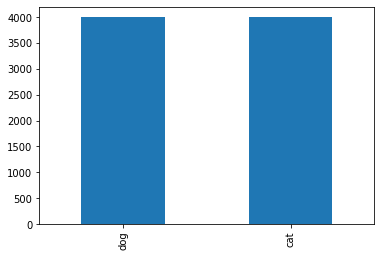

In [6]:
# number of cats and dogs
df_train['category'].value_counts().plot.bar()

#### Exibe uma amostra

Text(0.5, 1.0, 'cat.3623.jpg')

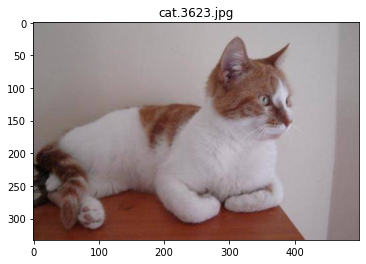

In [7]:
# Randomly chooses a file and displays its image
sample = random.choice(filenames)
image = load_img(DIR_TRAIN+sample)
plt.imshow(image)
plt.title(sample)

In [8]:
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)

JPEG
RGB
(499, 333)


### Representação de imagens RGB

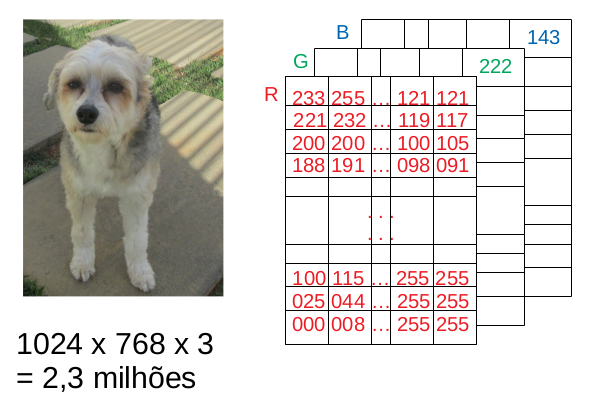

Em imagens coloridas, o padrão RGB (Red, Green, Blue) representa cada pixel como um vetor de três números para os três canais das cores primárias vermelho, verde e azul. Cada número varia de 0 a 255, representando a intensidade da cor correspondente. O três valores combinados formam a cor do pixel. Por exemplo, a cor violeta pode ser representada como 128, 0, 128, uma mistura de intensidade moderada de vermelho e azul, sem o verde.

Já em imagens em escala de cinza (*grayscale*), cada pixel é representado com um único número (entre 0 e 255), o qual determina o quão preto é o pixel (0 é preto e 255 é branco brilhante).

In [9]:
# convert image to numpy array
data = np.asarray(image)
# summarize shape
print(data.shape)

(333, 499, 3)


### Teste

In [10]:
# Read the images from the test directory and generates a pandas structure with the name of each file and the class of the image (cat or dog)
filenames = os.listdir(DIR_TEST)
categories = []
for filename in filenames:
    categories.append(filename.split('.')[0]) # category = file name

df_test = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [11]:
df_test.head()

,filename,category
0,dog.4803.jpg,dog
1,dog.4942.jpg,dog
2,cat.4602.jpg,cat
3,cat.4700.jpg,cat
4,dog.4469.jpg,dog


In [12]:
df_test.tail()

,filename,category
1995,cat.4036.jpg,cat
1996,cat.4848.jpg,cat
1997,cat.4798.jpg,cat
1998,cat.4512.jpg,cat
1999,cat.4687.jpg,cat


<AxesSubplot:>

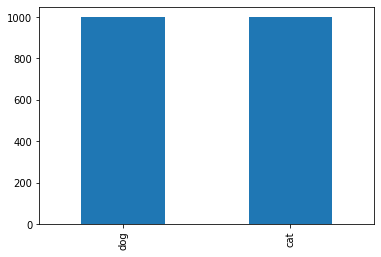

In [13]:
# number of cats and dogs
df_test['category'].value_counts().plot.bar()

#### Exibe uma amostra

Escolha um arquivo aleatório do conjunto de teste e exiba sua imagem

Text(0.5, 1.0, 'cat.4032.jpg')

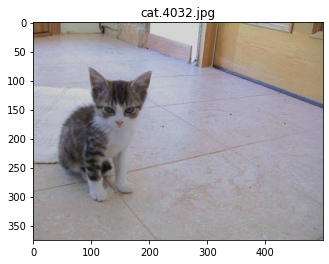

In [14]:
# Randomly chooses a file and displays its image
sample = random.choice(filenames)
image = load_img(DIR_TEST+sample)
plt.imshow(image)
plt.title(sample)

### Data Augmentation

*Data Augmentation* (aumento de dados) é uma técnica usada para expandir artificialmente o conjunto de dados de treinamento. Ela ajuda a evitar o problema de *overfitting*, que faz com que o modelo de treinamento fique muito ajustado aos dados usados para o treinamento, e não gera um bom desempenho em outros conjuntos de dados.

As abordagens para *data augmentation* alteram os dados de treino de forma a mudar a representação vetorial, mas mantendo o mesmo rótulo de classe. Algumas transformações populares são: grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, shift, brightness, and zoom..

Fazendo algumas dessas transformações nos dados de treino, é possível multiplicar o número de exemplos de treino, de forma a criar um modelo mais robusto.

Tutorial para configurar *data augmentation* de imagens em Keras: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

### Generador de Treino


In [15]:
batch_size = 15
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# Takes the dataframe and the path to a directory and generates batches. 
# The generated batches contain augmented/normalized data.
train_generator = train_datagen.flow_from_dataframe(
    df_train, 
    DIR_TRAIN, 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 8000 validated image filenames belonging to 2 classes.


### Generador de Teste

Um gerador de dados pode também ser usado para especificar o dataset de validação e o dataset de teste. Normalmente, uma instância separada de ImageDataGenerator é criada para que se possa configurar a mesma escala de pixels que aquela usada na instância ImageDataGenerator do dataset de treinamento, mas ela não usará *data augmentation*. Isso ocorre porque *data augmentation* é somente usada como uma técnica para expandir artificialmente o dataset de treinamento, para se melhorar o desempenho de um dataset menor.

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_test, 
    DIR_TEST, 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 2000 validated image filenames belonging to 2 classes.


### Exemplo das Imagens Aumentadas

In [17]:
df_example = df_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    df_example, 
    DIR_TRAIN, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


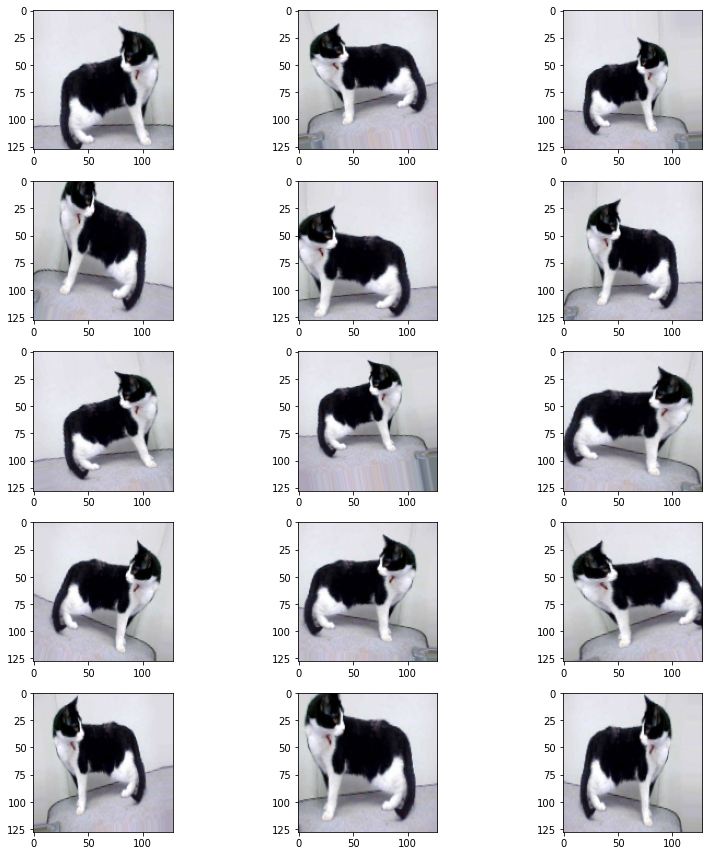

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Definição do Modelo


In [19]:
inputs = keras.Input(shape=(128,128,3))  # the shape of inputs
x = keras.layers.Flatten()(inputs)  ## flatten 3D RGB vector
x = keras.layers.Dense(units=32, activation="relu")(x)  ## first layer, 16 neurons, activation function ReLu
x = keras.layers.Dense(units=64, activation="relu")(x)  ## second layer, 32 neurons, activation function ReLu
x = keras.layers.Dense(units=32, activation="relu")(x)  ## third layer, 16 neurons, activation function ReLu
outputs = keras.layers.Dense(units=2, activation="softmax")(x)  # output layer, 10 neuron (digits from 0 to 9), activation function Softmax
model = keras.Model(inputs=inputs, outputs=outputs)

In [20]:
# Prints a summary of the network, showing its architecture and parameters.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 32)                1572896   
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,577,154
Trainable params: 1,577,154
Non-train

## Compilação do Modelo

In [21]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Treinamento do Modelo

Ajusta o modelo aos dados de treinamento.
Devem ser fornecidos os dados de treinamento e o número de épocas (iterações). Uma época é composta por uma única passagem por todos os exemplos do conjunto de treino.

Efetue o treinamento do modelo usando 3 épocas com os dados aumentados do gerador de treino *train_generator*.

Dica: use a função *fit*: https://keras.io/api/models/model_training_apis/

In [27]:
history = model.fit(train_generator, epochs = 3)
print(history.history)  # print per-epoch timeseries of metrics values

Epoch 1/3
534/534 [==============================] - 37s 70ms/step - loss: 0.6930 - accuracy: 0.5041
Epoch 2/3
534/534 [==============================] - 37s 70ms/step - loss: 0.6935 - accuracy: 0.4944
Epoch 3/3
534/534 [==============================] - 37s 70ms/step - loss: 0.6934 - accuracy: 0.4981
{'loss': [0.6930159330368042, 0.6934976577758789, 0.6934058666229248], 'accuracy': [0.5041249990463257, 0.49437499046325684, 0.49812498688697815]}


## Avaliação do Modelo

Avalie o desempenho da rede no conjunto de teste usando o gerador de dados aumentados *test_generator*.

Dica: use a função *evaluate*: https://keras.io/api/models/model_training_apis/

In [25]:
loss, acc = model.evaluate(test_generator)
print("Loss: %.2f" % loss, "\nAccuracy: %.2f" % acc)

134/134 [==============================] - 3s 19ms/step - loss: 0.6934 - accuracy: 0.5000
Loss: 0.69 
Accuracy: 0.50


## Predição


In [26]:
predictions = model.predict(test_generator)
preds = [np.argmax(x, axis=-1) for x in predictions]
print("Predictions: ", ["cat" if x == 0 else "dog" for x in preds[:30]]) # print the first 30 predictions
print("\nCorrect:     ", [x for x in df_test['category'][:30]])

Predictions:  ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']

Correct:      ['dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog']


# Fim

Esses foram os passos para criação de uma rede neural simples para classificação de imagens. Lembrando que para se obter uma melhor eficácia, devem ser adicionadas algumas camadas de Redes Neurais Convolucionais (CNN), que é assunto do próximo curso.

-------------------------------------------